# 라이브러리 로드

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
df_train = pd.read_csv('../data/titanic/train.csv')
df_test = pd.read_csv('../data/titanic/test.csv')

In [4]:
full_data = [df_train, df_test]

# Feature engineering

## Name/Title

### 첫 번째 방식

In [5]:
# lets extract the Salutations
for dataset in full_data:
    dataset['Title1'] = dataset.Name.str.extract('([A-Za-z]+)\.')

In [6]:
#Checking the Initials with the Sex
pd.crosstab(df_train.Title1, df_train.Sex).T.style.background_gradient(cmap='summer_r')

Title1,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [7]:
for dataset in full_data:
    dataset['Title1'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major',
                              'Lady', 'Countess', 'Jonkheer', 'Col',
                              'Rev', 'Capt', 'Sir', 'Don', 'Dona'],
                             ['Miss', 'Miss', 'Miss', 'Mr', 'Mr',
                              'Mrs', 'Mrs', 'Other', 'Other', 'Other',
                              'Mr', 'Mr', 'Mr', 'Mr'], inplace=True)

In [8]:
Title_list = []
for dataset in full_data:
    Title_list.append(dict(dataset.groupby('Title1')['Age'].mean()))
    print(Title_list[-1])

{'Master': 4.574166666666667, 'Miss': 21.86, 'Mr': 32.73960880195599, 'Mrs': 35.981818181818184, 'Other': 45.888888888888886}
{'Master': 7.406470588235294, 'Miss': 21.774843750000002, 'Mr': 32.15135135135135, 'Mrs': 38.903225806451616, 'Other': 42.75}


<AxesSubplot:xlabel='Title1'>

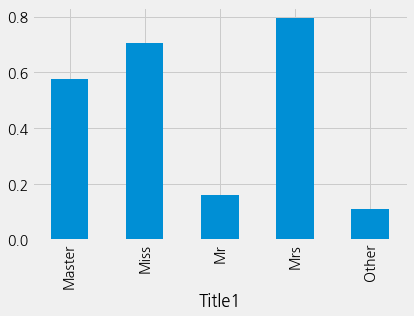

In [9]:
df_train.groupby('Title1')['Survived'].mean().plot.bar()

### 두 번째 방식

In [10]:
# Get title from Name
for dataset in full_data:
    dataset_title = [i.split(",")[1].split('.')[0].strip() for i in dataset.Name]
    dataset['Title2'] = pd.Series(dataset_title)
    

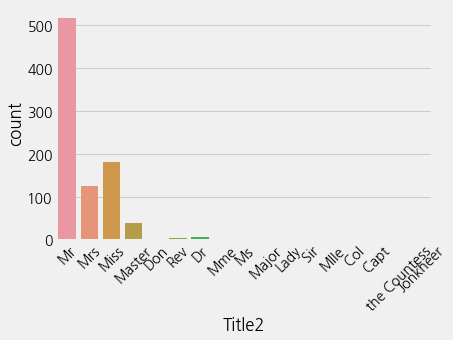

In [11]:
g = sns.countplot(x='Title2', data=df_train)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [12]:
for dataset in full_data:
    # Convert to categorical values Title2
    dataset["Title2"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare', inplace=True)
    dataset['Title2'].replace(['Ms', 'Mme', 'Mlle', 'Mrs'], ['Miss', 'Miss', 'Miss', 'Miss'], inplace=True)

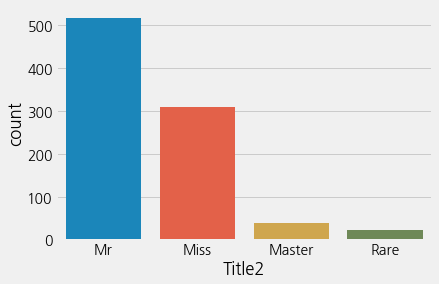

In [13]:
g = sns.countplot(x=df_train['Title2'])

### 추가적인 정보

- Name의 길이를 새로운 feature로 생성

In [14]:
df_train['Name_length'] = df_train['Name'].apply(len)

## Fill missing values about Age

### 첫 번째 방식

- Age 에는 결측치값이 177(train) + 86(test) 개가 있음. 이를 채우기 위해서 title + statistics를 사용.
- Name 컬럼에 Miss, Mr, Mrs, Master 같은 호칭이 존재.
- 이러한 호칭을 가지고 승객들을 그룹핑 한후, 이를 토대로 평균값을 이용해서 결측치를 처리함.

-> 이렇게 하는 이유??? 나이가 생존율에 영향을 끼치는기 때문. 예를 들어, 아주 어린 나이일 경우, 생존율이 높다는 등...
-> 전체 데이터셋에 평균을 내서 하는 것은 이러한 나이와 생존의 관계를 고려하지 않는 방식임.

In [15]:
for dataset, title in zip(full_data, Title_list):
    dataset['Age1'] = 0
    dataset.loc[(dataset.Age.isnull()) & (dataset.Title1=='Mr'), 'Age1'] = title['Mr']
    dataset.loc[(dataset.Age.isnull()) & (dataset.Title1=='Mrs'), 'Age1'] = title['Mrs']
    dataset.loc[(dataset.Age.isnull()) & (dataset.Title1=='Master'), 'Age1'] = title['Master']
    dataset.loc[(dataset.Age.isnull()) & (dataset.Title1=='Miss'), 'Age1'] = title['Miss']
    dataset.loc[(dataset.Age.isnull()) & (dataset.Title1=='Other'), 'Age1'] = title['Other']

### 두 번째 방식

- 특정 하위 분포에 생존율이 더 높음 (어린이 같은 경우)
- Age의 특성을 유지하고 결측치를 처리하는 것이 중요.
- Age 와 관련된 Parch, Pclass, SibSp를 이용해서 Age의 결측치를 채움

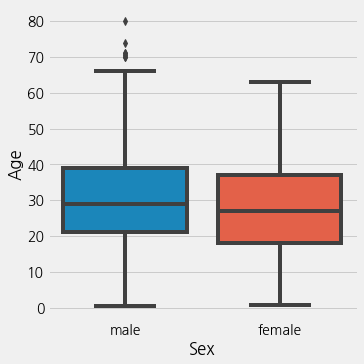

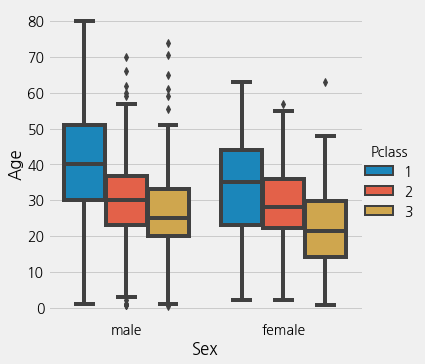

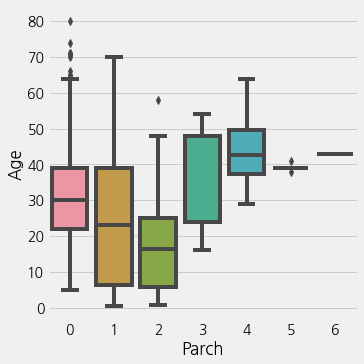

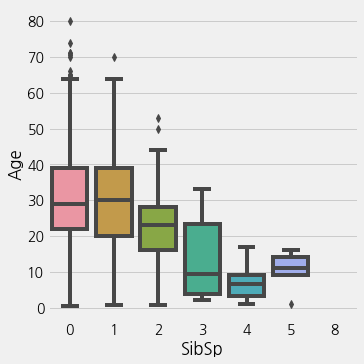

In [16]:
# Explore Agevs Sex, Parch, Pclass and SibSP
g = sns.catplot(y='Age', x='Sex', data=df_train, kind='box')
g = sns.catplot(y='Age', x='Sex', hue='Pclass', data=df_train, kind='box')
g = sns.catplot(y='Age', x='Parch', data=df_train, kind='box')
g = sns.catplot(y='Age', x='SibSp', data=df_train, kind='box')

- 남성과 여성은 나이 분포는 비슷. 나이에 대한 결측치를 처리할 때 성별을 이용하는 것은 좋지 않음.

- Pclass의 경우, 1등석, 2등석, 3등석별로 나이 분포가 다름.

- Parch가 크면 클수록 나이가 많고, SibSp가 크면 클수록 나이가 적음.

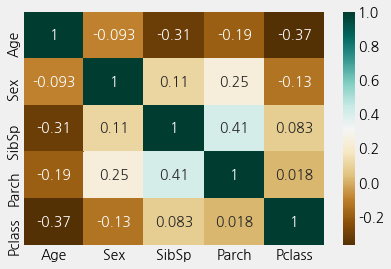

In [17]:
corr_data = df_train[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].copy()
corr_data.Sex = corr_data.Sex.map({'male': 0, 'female': 1})
g = sns.heatmap(corr_data.corr(), cmap='BrBG', annot=True)

- Age는 Sex와 상관없지만, Pclass, Parch, SibSp와 음의 상관 관계가 있음.

- Parch를 가지고 Age를 확인했을 때, Parch가 증가함에 따라 나이가 증가했지만, 상관관계에서는 음의 상관 관계를 가지고 있음.

- Age에 대한 결측치를 채우는 아이디어는 Pclass, Parch, SibSp에 따라 비슷한 행 중간값을 채우는 것.

In [18]:
# Index of NaN age rows about train
df_train['Age2'] = 0
train_index_nan_age = list(df_train.Age[df_train.Age.isnull()].index)
for i in train_index_nan_age:
    age_med = df_train.Age.median()
    age_pred = df_train.Age[(df_train.SibSp == df_train.iloc[i].SibSp) &
                       (df_train.Parch == df_train.iloc[i].Parch) &
                       (df_train.Pclass == df_train.iloc[i].Pclass)].median()
    if not np.isnan(age_pred):
        df_train.Age2.iat[i] = age_pred
    else:
        df_train.Age2.iat[i] = age_med

In [19]:
# Index of NaN age rows about train
df_test['Age2'] = 0
train_index_nan_age = list(df_test.Age[df_test.Age.isnull()].index)
for i in train_index_nan_age:
    age_med = df_test.Age.median()
    age_pred = df_test.Age[(df_test.SibSp == df_test.iloc[i].SibSp) &
                       (df_test.Parch == df_test.iloc[i].Parch) &
                       (df_test.Pclass == df_test.iloc[i].Pclass)].median()
    if not np.isnan(age_pred):
        df_test.Age2.iat[i] = age_pred
    else:
        df_test.Age2.iat[i] = age_med

## Fill missing values about Embarked

- Embarked 는 Null value가 2개. S에서 가장 많은 탑승객이 있었으므로, 분포에 영향을 안 끼치게 하기 위해서 S로 채움.

In [20]:
for dataset in full_data:
    dataset.Embarked.fillna('S', inplace=True)

## Fare

### Fill missing values about Fare

In [21]:
df_train.Fare.isnull().sum(), df_test.Fare.isnull().sum()

(0, 1)

In [22]:
df_test.Fare.fillna(df_test.Fare.mean(), inplace=True)

### apply log function

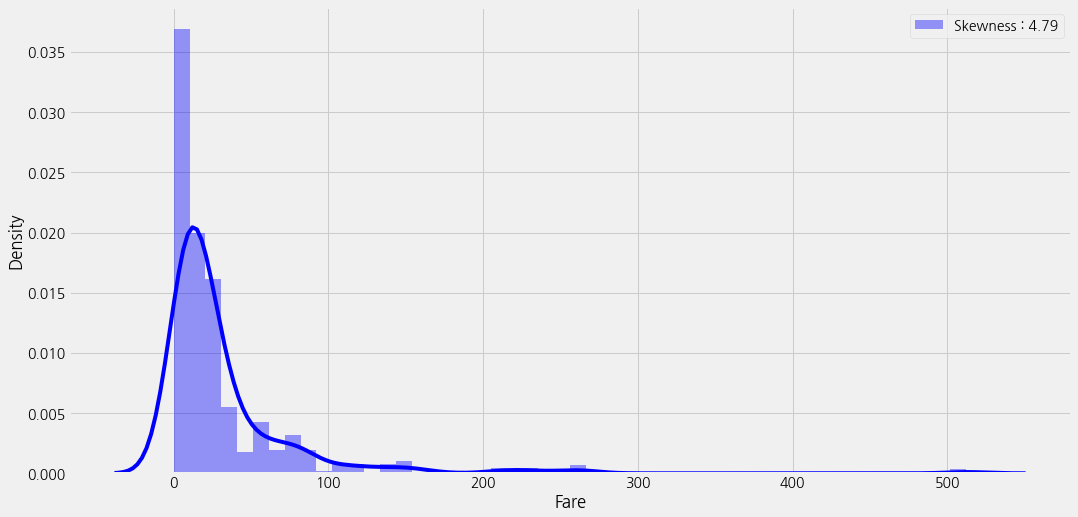

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

- 그래프를 보면, distribution이 매우 비대칭임을 알 수 있음. (high skewness)

- 이를 그대로 모델이 넣는다면, 모델이 잘못 학습할 가능성이 있음. WHY? 몇개 없는 outlier에 대해서 너무 민감하게 반응해서

- outlier의 영향을 줄이기 위해 Fare 에 log를 취함. 스케일링을 통해서 Fare의 분포를 정규분포 형태로 만들어주는 것.

In [24]:
def apply_log(x):
    return np.log(x) if x > 0 else 0

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].apply(apply_log)

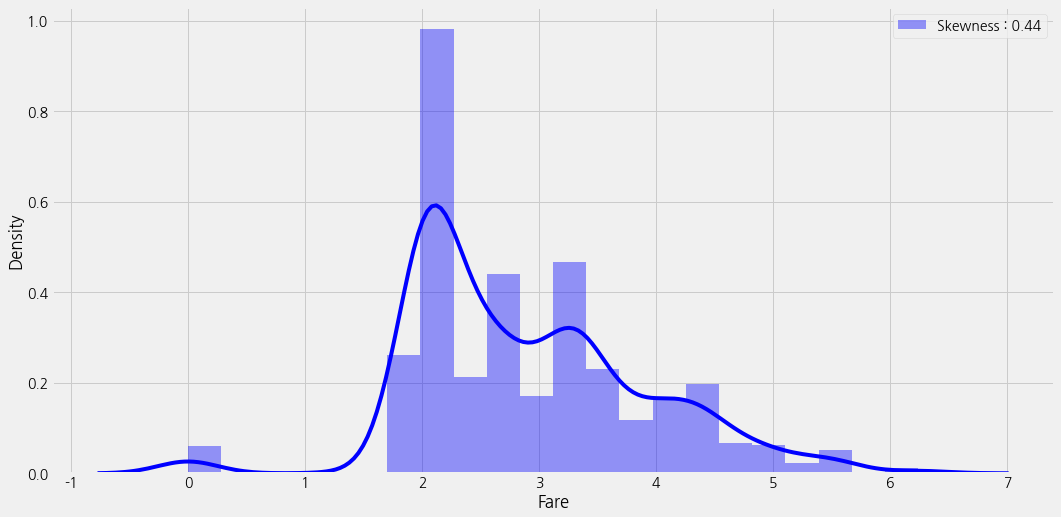

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness : {:.2f}'.format(df_train['Fare'].skew()), ax=ax)
g = g.legend(loc='best')

### 첫 번째 방식

- Continuous feature를 그대로 사용해도 되지만, 몇개의 group으로 나누어 category 화 할 수 있음.

- 물론, continuous feature를 categorical feature로 바꾸면 information loss가 발생할 수 있음.

In [26]:
df_copy = df_train.copy()
df_copy['Fare_cat1'] = pd.qcut(df_copy.Fare, 4)

display(df_copy.groupby(['Fare_cat1'])['Survived'].mean().to_frame().style.background_gradient(cmap='summer_r'))
del df_copy

,Survived
Fare_cat1,
"(-0.001, 2.068]",0.197309
"(2.068, 2.671]",0.303571
"(2.671, 3.434]",0.454955
"(3.434, 6.239]",0.581081


In [27]:
df_train['Fare_cat1'] = pd.qcut(df_train.Fare, 4, labels=False)
df_test['Fare_cat1'] = pd.qcut(df_test.Fare, 4, labels=False)

## Age

### 첫 번째 방식

- Continuous feature를 그대로 사용해도 되지만, 몇개의 group으로 나누어 category 화 할 수 있음.

- 물론, continuous feature를 categorical feature로 바꾸면 information loss가 발생할 수 있음.

In [28]:
def category_age1(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

In [29]:
for dataset in full_data:
    dataset['Age_cat1'] = dataset.Age.apply(category_age1)

### 두 번째 방식

- 첫 번째 방식은 0-80에서 10 간격으로 그룹핑을 한거라면,

- 두 번째 방식은 청소년, 청년, 중년, 노년으로 그룹핑한 것.

In [30]:
def category_age2(x):
    if x <= 16:
        return 0
    elif x <= 32:
        return 1
    elif x <= 48:
        return 2
    elif x <= 64:
        return 3
    else:
        return 4

In [31]:
for dataset in full_data:
    dataset['Age_cat2'] = dataset.Age.apply(category_age2)

## Family Size

### 첫 번째 방식

- Parch + SibSp를 이용해서 가족 구성원수와 솔로인지 아닌지를 구분할 수 있는 새로운 feature를 만들 수 있음.

- 이를 통해서 생존율이 가족 규모와 관련 있는지 파악할 수 있음.

- Family Size + Alone

In [32]:
df_train['Family_Size1'] = 0
df_train['Family_Size1'] = df_train['Parch'] + df_train['SibSp']

df_train['Alone'] = 0
df_train.loc[df_train.Family_Size1 == 0, 'Alone'] = 1

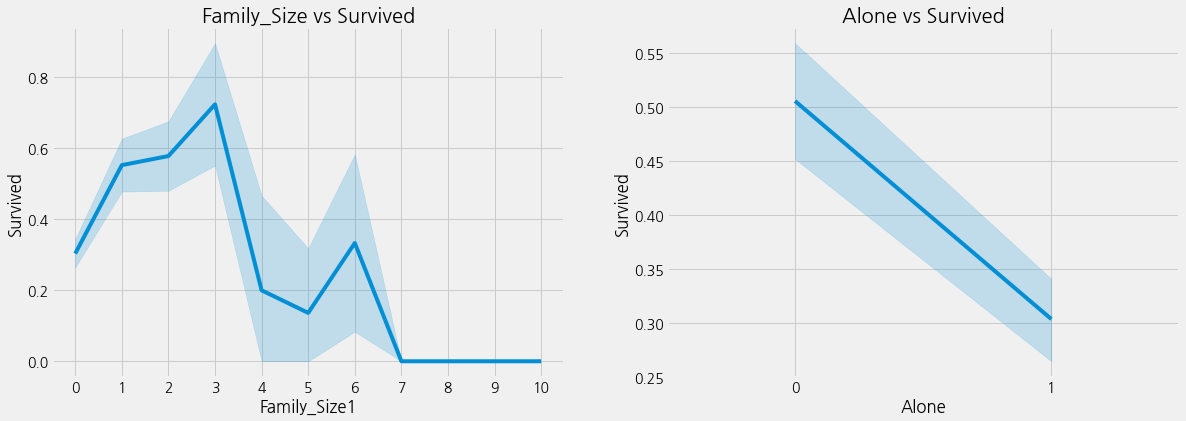

In [33]:
f, ax = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot('Family_Size1', 'Survived', data=df_train, ax=ax[0])
ax[0].set_xticks(range(0, 11))
ax[0].set_title('Family_Size vs Survived')

sns.lineplot('Alone', 'Survived', data=df_train, ax=ax[1])
ax[1].set_xticks(range(0, 2))
ax[1].set_xlim([-0.5, 1.5])
ax[1].set_title('Alone vs Survived')
plt.show()

- Family_Size = 0 : 혼자임을 뜻함. 혼자는 생존율이 낮음.
- Family_Size > 4 : 이 경우에도 생존율이 낮음.

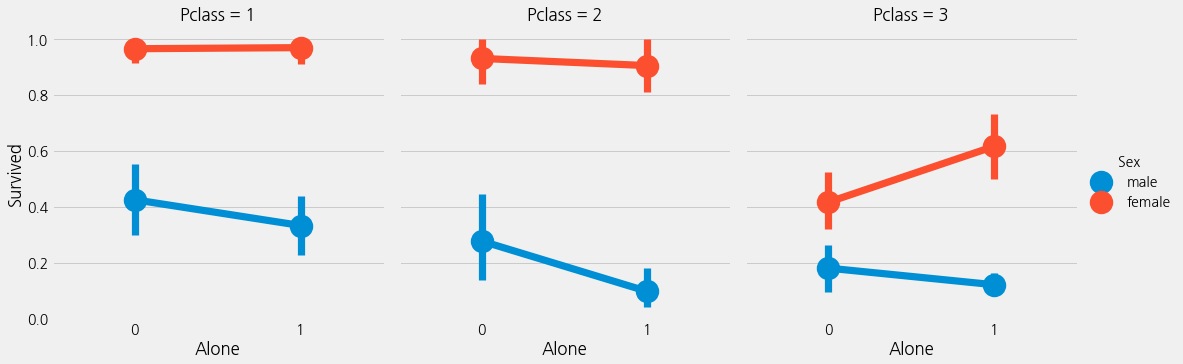

In [34]:
sns.factorplot('Alone', 'Survived', data=df_train, hue='Sex', col='Pclass')
plt.show()

- Pclass3를 제외하고 가족이 있는 여성보다 혼자 있는 여성의 생존율이 높음.

- 혼자 있는 것은 성별이나 Pclass에 관계없이 생존율이 낮다는 것을 알 수 있음.

### 두 번째 방식

- Parch + SibSp를 이용해서 가족 구성원수와 솔로인지 아닌지를 구분할 수 있는 새로운 feature를 만들 수 있음.

- 이를 통해서 생존율이 가족 규모와 관련 있는지 파악할 수 있음.

- 가족 규모에 따른 그룹핑을 통해 새로운 feature를 만듬.

In [35]:
# Create a family size descriptor from SibSp and Parch
df_train['Family_Size2'] = df_train['SibSp'] + df_train['Parch'] + 1

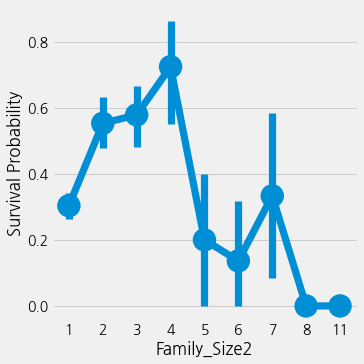

In [36]:
g = sns.catplot(x='Family_Size2', y='Survived', data=df_train, kind='point')
g = g.set_ylabels('Survival Probability')

- 가족 구성원의 수가 중요한 역할을 하는 것처럼 보임. 대 가족의 경우 생존화률이 낮다는 것을 알 수 있음.

- 그리고 추가적으로 가족 구성원의 수를 가지고 4가지의 범주형 데이터를 만들 수 있음.

In [37]:
# Create new feature of family size
df_train['Single'] = df_train['Family_Size2'].map(lambda s: 1 if s == 1 else 0)
df_train['SmallF'] = df_train['Family_Size2'].map(lambda s: 1 if s == 2 else 0)
df_train['MedF'] = df_train['Family_Size2'].map(lambda s: 1 if 3 <= s <= 4 else 0)
df_train['LargeF'] = df_train['Family_Size2'].map(lambda s: 1 if s>= 5 else 0)

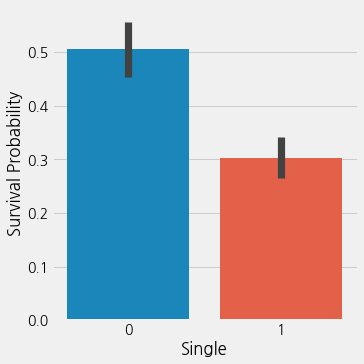

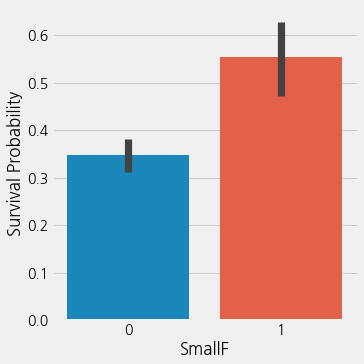

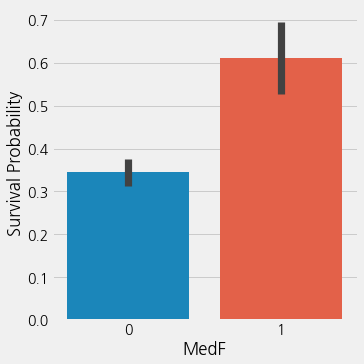

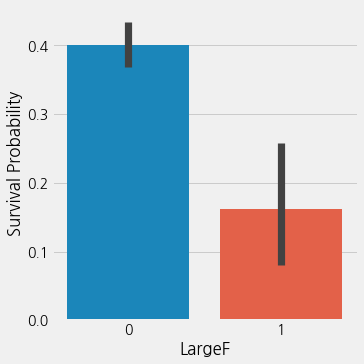

In [38]:
g = sns.catplot(x='Single', y='Survived', data=df_train, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='SmallF', y='Survived', data=df_train, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='MedF', y='Survived', data=df_train, kind='bar')
g = g.set_ylabels('Survival Probability')

g = sns.catplot(x='LargeF', y='Survived', data=df_train, kind='bar')
g = g.set_ylabels('Survival Probability')

- 가족 구성원의 수에 따른 4개의 범주를 봤을 때, Small, Medium의 경우 생존율이 Single, Large의 경우보다 높음

## Cabin

### 첫 번째 방식

In [39]:
df_train.Cabin.head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [40]:
df_train.Cabin.describe()

count             204
unique            147
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

In [41]:
df_train.Cabin.isnull().sum()

687

- 대부분의 데이터가 결측치임.

- 객실 정보가 없는 경구(결측치인 경우), NaN 값으로 두는 것이 아니라 객실 정보가 없다고 표시해서 feature로 사용

In [42]:
# Replace the Cabin number by the type of cabin 'X' if not
df_train['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df_train['Cabin']])

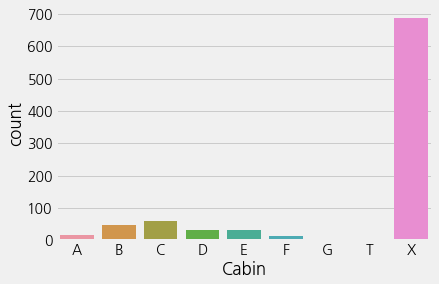

In [43]:
g = sns.countplot(x=df_train["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

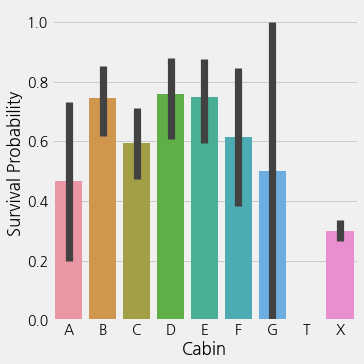

In [44]:
g = sns.catplot(y='Survived', x='Cabin', data=df_train, kind='bar', order=['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])
g = g.set_ylabels('Survival Probability')

객실이있는 승객 수가 적기 때문에 생존 확률은 중요한 표준 편차를 가지며 다른 책상에있는 승객의 생존 확률을 구분할 수 없습니다.

그러나 우리는 일반적으로 객실이있는 승객이 (X)가없는 승객보다 생존 가능성이 더 높다는 것을 알 수 있습니다.

특히 객실 B, C, D, E 및 F에 해당됩니다.

- 객실이 있는 승객의 수가 적기 때문에 생존율은 중요한 표준 편차를 가지고 있고, 프런트에 따른 생존율은 구분할 수 없음.

- 일반적으로 객실 정보가 있는 승객이 객실 정보가 업슨 승객보다 생존율이 높다는 것을 알 수 있음. (T의 경우 제외)

- B, C, D, E, F의 경우는 생존율이 50%가 넘음.

### 두 번째 방식

- 객실 정보의 유무로만 판단

In [45]:
df_train['Has_Cabin'] = df_train['Cabin'].apply(lambda x: 0 if type(x) == float else 1)

## Ticket

In [46]:
dataset.Ticket.head()

0     330911
1     363272
2     240276
3     315154
4    3101298
Name: Ticket, dtype: object

- 동일한 접두사를 가지고 있는 티겟은 동일한 객실에 대해 에약 될 수 있음을 의미함. 따라서 티겟을 통해서 선실내의 객실에 대한 실제 배치를 파악할 수 있음.

- 그리고 동일한 접두사를 가지고 잇는 티겟은 비슷한 Pclass와 비슷한 생존율을 가지고 있음.

- 따라서 티겟의 접두사를 정보로 쓰는 것이 생존율 예측에 도움이 될 수 있음.

In [47]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(df_train.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")

df_train.Ticket = Ticket
df_train.Ticket.head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

## Converting String Values into Numeric

- 모델은 문자열을 학습할 수 없음. 따라서 실수값으로 바꿔줘야 됨.

### Sex

In [48]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})

### Title

In [49]:
df_train['Title1'] = df_train['Title1'].map({'Master': 0, 'Miss':1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

In [50]:
df_train['Title2'] = df_train['Title2'].map({'Master': 0, 'Miss': 1, 'Mr':2, 'Rare': 4})

### Embarked

In [51]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

### Cabin

In [52]:
keys = np.sort(df_train.Cabin.unique())
values = [i for i in range(len(df_train.Cabin.unique()))]
Cabin_dict = dict(zip(keys, values))
df_train['Cabin'] = df_train['Cabin'].map(Cabin_dict)

### Ticket

In [53]:
keys = np.sort(df_train.Ticket.unique())
values = [i for i in range(len(df_train.Ticket.unique()))]
Ticket_dict = dict(zip(keys, values))
df_train['Ticket'] = df_train['Ticket'].map(Ticket_dict)

## Apply one-hot encoding

- 모델에 따라서 one-hot encoding을 해야 하는 경우가 있음.

- one-hot encoding하면 차원이 늘어나기 때문에 모델이 무거워짐.

### Sex

In [54]:
df_train = pd.get_dummies(df_train, columns=['Sex'], prefix='Sex')

### Title

In [55]:
df_train = pd.get_dummies(df_train, columns=['Title1'], prefix='Title')

### Embarked

In [56]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')

### Pclass

In [57]:
df_train = pd.get_dummies(df_train, columns=['Pclass'], prefix='P')

### Cabin

In [58]:
df_train = pd.get_dummies(df_train, columns=['Cabin'], prefix='Cabin')

### Ticket

In [59]:
df_train = pd.get_dummies(df_train, columns=['Ticket'], prefix='T')

## Drop redundant Features

- 필요 없는 feaature를 제거

# pearson correlation

$$
\begin{align}
r_{xy} =
\dfrac{\text{Cov}\left(x, y\right)}{S_xS_y} =
\dfrac{{1 \over n-1}\sum_{i=1}^n\left(x_i-\bar{x}\right)\left(y_i-\bar{y}\right)}{S_xS_y}
\end{align}
$$

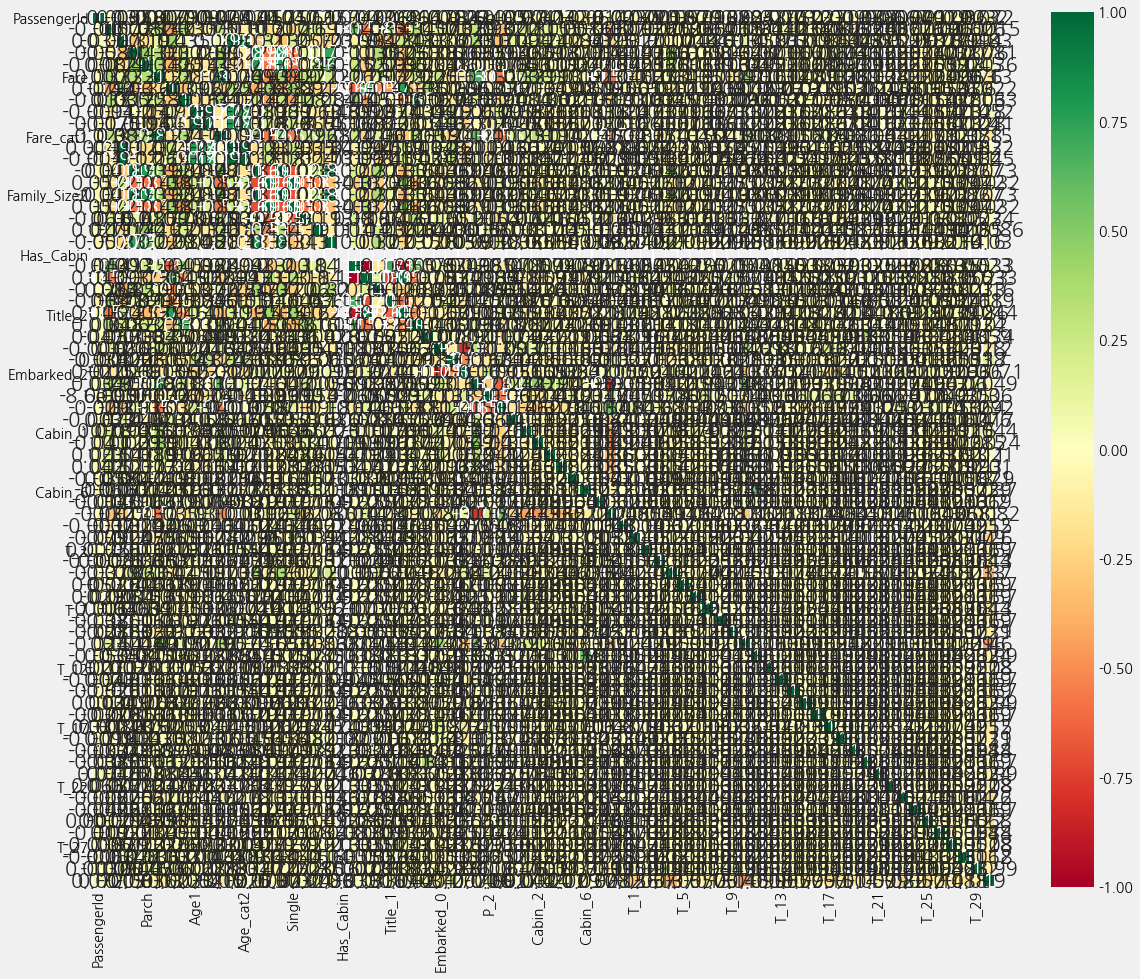

In [60]:
sns.heatmap(df_train.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()